In [49]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import measure, exposure
import matplotlib
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [52]:
from config import *

In [53]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)
    
import my_io as io

In [54]:
# Parameters
random_seed = 1

# Import metadata information

In [55]:
df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

,Pos,Grades,Stage,Directory
0,B1,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1,B3,2,I,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2,B5,2,II,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3,C6,AT,AT,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4,D7,3,IIIA,Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7


In [56]:
datasets = df_metadata.Directory.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

In [57]:
print(datasets)

['ROI001_B1', 'ROI005_B3', 'ROI006_B5', 'ROI007_C6', 'ROI008_D7', 'ROI009_D9', 'ROI012_E1', 'ROI015_B6', 'ROI016_F3', 'ROI017_F2', 'ROI018_G1', 'ROI019_G5', 'ROI020_E5', 'ROI021_E7']


In [58]:
# Define which dataset to work on 
dataset = datasets[0]
path_ex_level = io.create_folder(dataset, data_ex_level)

Folder is already there


# Read marker images and cell mask

In [59]:
imgs, markers = io.read_img(dataset, data_ROI)
marker2img = dict(zip(markers, imgs))
print(f'Image stack shape of {imgs.shape}')

Image stack shape of (22, 800, 800)


In [60]:
mask = io.read_cell_mask(dataset, data_ROI)
print(f'Mask shape of {mask.shape}')
print(f'Number of cell is {mask.max()}')

Mask shape of (800, 800)
Number of cell is 3095


# Read expresssion level for each segmented region 

In [61]:
def get_cell_expression_level(marker2img_dict, mask, p2, p98):
    # Get each cell region 
    morph_prop = pd.DataFrame(measure.regionprops_table(mask, properties=['label', 'area'])).set_index('label')
    
    # Multiple each cell region by mean intensity 
    df_list = []
    for marker, img in marker2img_dict.items():
#         p2, p98 = np.percentile(img, (0.1, 99.9))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        exp_prop = pd.DataFrame(measure.regionprops_table(mask, img, properties=['label','mean_intensity'])).set_index('label')
        df = pd.DataFrame(exp_prop.values, index=morph_prop.index, columns=[marker])
        df_list.append(df)
        
    df_exp = pd.concat(df_list, axis=1)
    return df_exp 

p2, p98 = np.percentile(imgs, (20.0, 99.0))
df_exp = get_cell_expression_level(marker2img, mask, p2, p98)

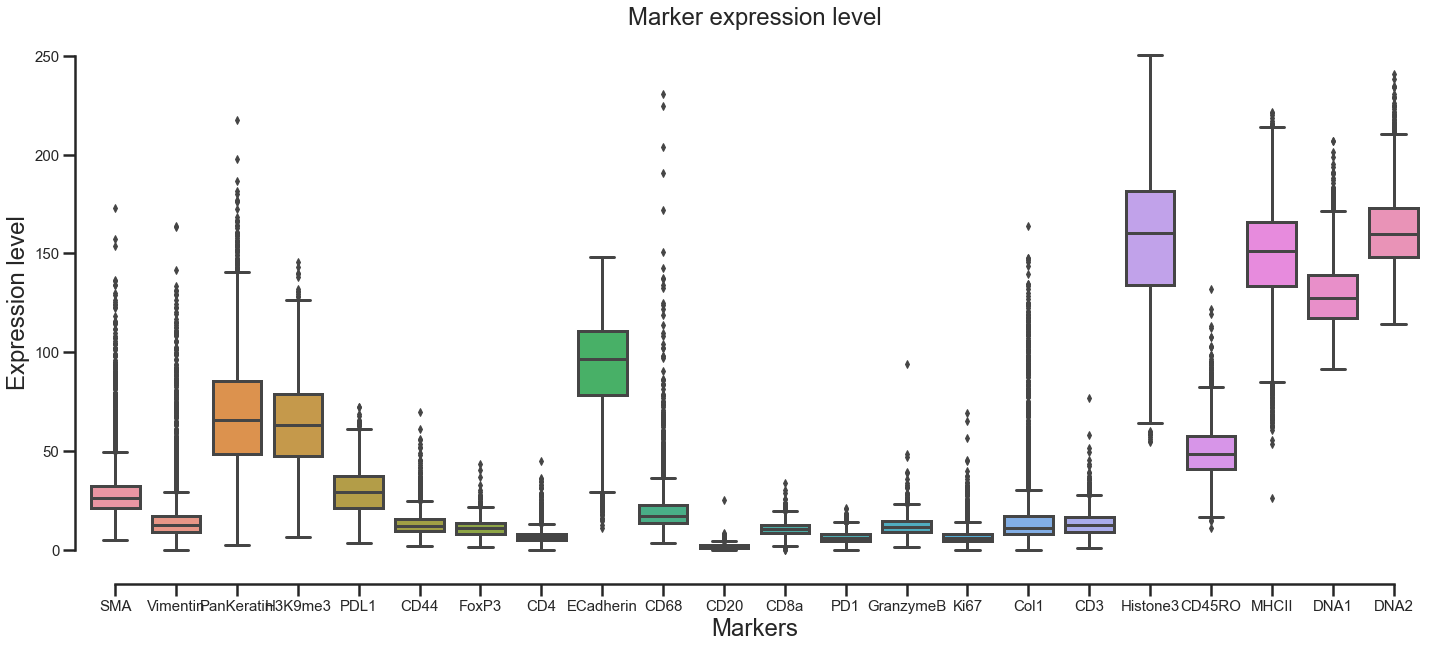

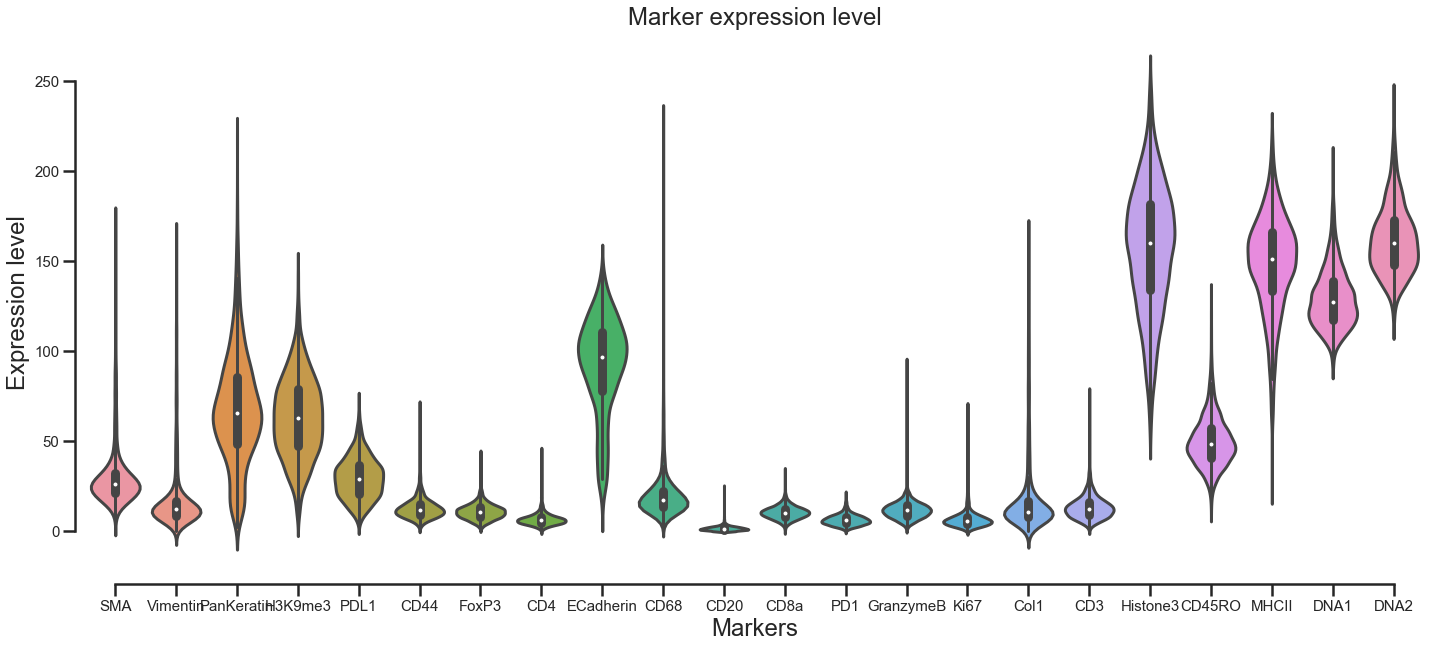

In [62]:
def expression_level_plot(df, path, figsize=(24,10)):
    sns.set_style("ticks")
    sns.set_context("poster")
    df_melt = pd.melt(df)
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.boxplot(x='variable',y='value', data=df_melt)
    ax.tick_params(labelsize=15)
    ax.set_title('Marker expression level')
    ax.set_xlabel('Markers')
    ax.set_ylabel('Expression level')
    sns.despine(fig, ax, offset=10, trim=True, bottom=False, left=False);
    fig.savefig(path / 'marker_expresion_mean_boxplot.png', bbox_inches='tight')
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.violinplot(x='variable',y='value', data=df_melt, scale='width')
    ax.tick_params(labelsize=15)
    ax.set_title('Marker expression level')
    ax.set_xlabel('Markers')
    ax.set_ylabel('Expression level')
    sns.despine(fig, ax, offset=10, trim=True, bottom=False, left=False);
    fig.savefig(path / 'marker_expresion_mean_violinplot.png', bbox_inches='tight')
    
expression_level_plot(df_exp, path_ex_level)

In [63]:
# Category of markers
Stroma = ['SMA', 'Vimentin', 'CD44', 'ECadherin', 'Col1']
DNA = ['DNA1', 'DNA2', 'H3K9me3', 'Histone3']
Immune = ['PDL1', 'Foxp3', 'CD4', 'CD68', 'CD20', 'CD8a', 'PD1', 'GranzymeB', 'CD3', 'Ki67', 'CD45RO']
Epithelial = ['ECadherin', 'PanKeratin', 'Ki67', 'MHCII']

n_category = 4

# Marker list
markers = df_exp.corr().index.to_list()

# Get colors and colormap
vals = np.linspace(0, 0.4, n_category)
colors = plt.cm.Set1(vals)
my_cmap_dict = dict(zip(np.arange(n_category), colors))
my_cmap_dict[''] = np.nan

# Create pandas df colors
df_colors = pd.DataFrame(index = df_exp.corr().index)
df_colors['Stroma'] = np.where(df_colors.index.isin(Stroma), 1, np.nan)
df_colors['Immune'] = np.where(df_colors.index.isin(Immune), 2, np.nan)
df_colors['Epithelial'] = np.where(df_colors.index.isin(Epithelial), 0, np.nan)
df_colors['DNA'] = np.where(df_colors.index.isin(DNA), 3, np.nan)
df_colors = df_colors.fillna("").applymap(my_cmap_dict.get)

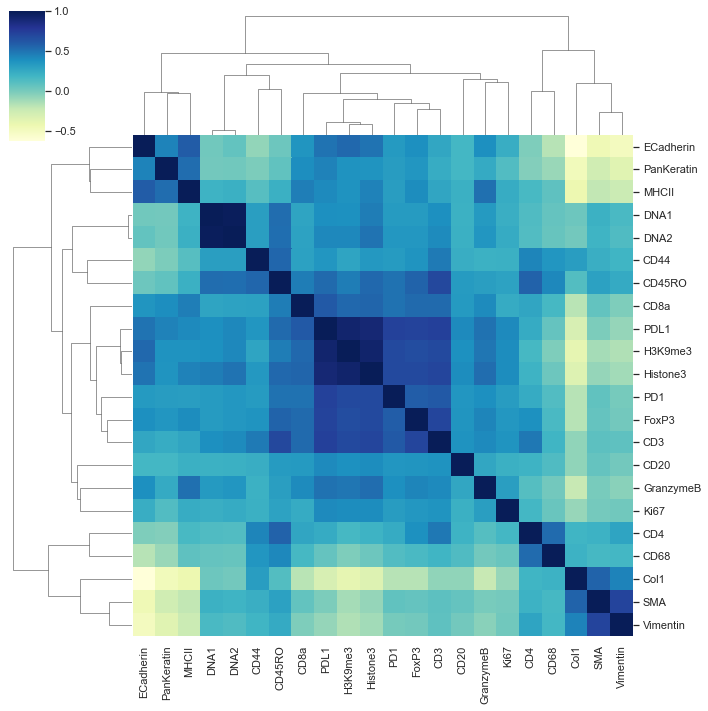

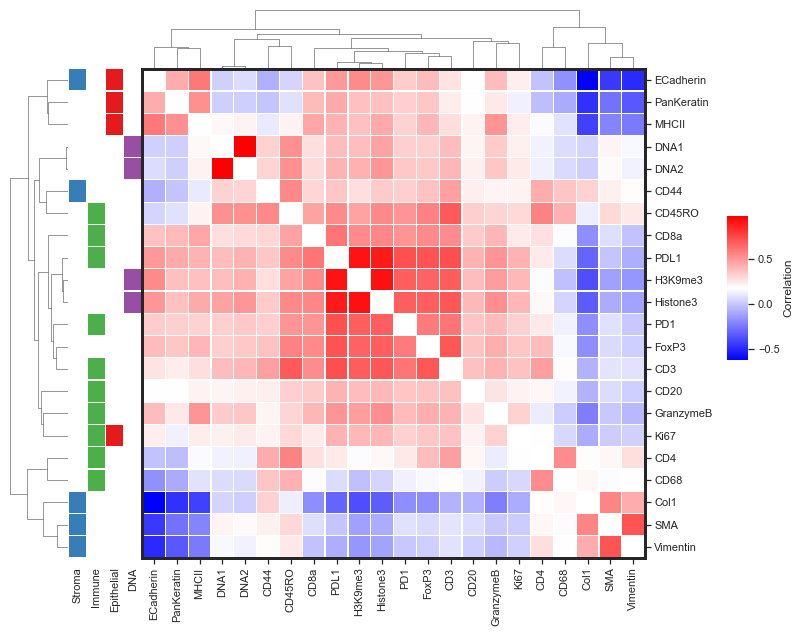

In [64]:
def plot_cluster(df, path, df_colors, cellSizePixels=20):
    sns.set_style("white")
    sns.set_context('notebook')
    g0 = sns.clustermap(df, cmap="YlGnBu")
    mask = np.diag(np.diag(np.ones_like(df, dtype=np.bool)))
    mask = mask[np.argsort(g0.dendrogram_row.reordered_ind), :]
    mask = mask[:, np.argsort(g0.dendrogram_col.reordered_ind)]
        
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth = matplotlib.rcParams['figure.subplot.right']-matplotlib.rcParams['figure.subplot.left']
    marginHeight = matplotlib.rcParams['figure.subplot.top']-matplotlib.rcParams['figure.subplot.bottom']
    Ny,Nx = df.shape
    figWidth = (Nx*cellSizePixels/dpi)/0.9/marginWidth
    figHeigh = (Ny*cellSizePixels/dpi)/0.9/marginHeight
    
    g = sns.clustermap(df, mask=mask, 
                       cbar_kws={'fraction': 0.01}, 
                       cmap="bwr", 
                       row_colors=df_colors, 
                       linewidth=0.2, 
                       dendrogram_ratio=(.1, .1),
                       figsize=(figWidth, figHeigh),
                       cbar_pos=(1.02, .40, .03, .2))
    g.fig.set_size_inches(10, 10)
    g.ax_heatmap.tick_params(bottom=True)
    
    # calculate the size of the heatmap axes
    axWidth = (Nx*cellSizePixels)/(figWidth*dpi)
    axHeight = (Ny*cellSizePixels)/(figHeigh*dpi)

    # resize heatmap
    ax_heatmap_orig_pos = g.ax_heatmap.get_position()
    g.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, 
                                  axWidth, axHeight])

    # resize dendrograms to match
    ax_row_orig_pos = g.ax_row_dendrogram.get_position()
    g.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
                                         ax_row_orig_pos.width, axHeight])
    ax_row_orig_pos = g.ax_row_colors.get_position()
    g.ax_row_colors.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
                                         ax_row_orig_pos.width, axHeight])
    ax_col_orig_pos = g.ax_col_dendrogram.get_position()
    g.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])
    
    # Change colorbar label position
    cbar = g.ax_heatmap.collections[0].colorbar
    cbar.set_label('Correlation', fontsize=12)
    
    for _, spine in g.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)
        
    g.savefig(path / 'marker_mean_corr.png', bbox_inches='tight')

plot_cluster(df_exp.corr(), path_ex_level, df_colors)

# Loop 

In [65]:
%matplotlib agg

df_appended = []

for dataset in datasets:
    print(f'Working on {dataset}')
    # Create figure directory if not exist
    path_ex_level = io.create_folder(dataset, data_ex_level)
    # Read imgs, markers and cell mask info
    imgs, markers = io.read_img(dataset, data_ROI)
    marker2img = dict(zip(markers, imgs))
    mask = io.read_cell_mask(dataset, data_ROI)
    # Show expression level
    p2, p98 = np.percentile(imgs, (20.0, 99.0))
    df_exp = get_cell_expression_level(marker2img, mask, p2, p98)
    expression_level_plot(df_exp, path_ex_level)
    # Correlation Plot
    plot_cluster(df_exp.corr(), path_ex_level, df_colors)
    df_appended.append(df_exp)

Working on ROI001_B1
Folder is already there
Working on ROI005_B3
Folder is already there
Working on ROI006_B5
Folder is already there
Working on ROI007_C6
Folder is already there
Working on ROI008_D7
Folder is already there
Working on ROI009_D9
Folder is already there


<ipython-input-62-f8f412983a26>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


Working on ROI012_E1
Folder is already there
Working on ROI015_B6
Folder is already there
Working on ROI016_F3
Folder is already there
Working on ROI017_F2
Folder is already there
Working on ROI018_G1
Folder is already there
Working on ROI019_G5
Folder is already there
Working on ROI020_E5
Folder is already there
Working on ROI021_E7
Folder is already there


In [66]:
df_all = pd.concat(df_appended)
df_all

,SMA,Vimentin,PanKeratin,H3K9me3,PDL1,CD44,FoxP3,CD4,ECadherin,CD68,...,PD1,GranzymeB,Ki67,Col1,CD3,Histone3,CD45RO,MHCII,DNA1,DNA2
label,,,,,,,,,,,,,,,,,,,,,
1,12.626761,4.605634,33.788732,39.823944,15.936620,4.887324,6.246479,3.711268,66.035211,14.429577,...,3.795775,5.429577,4.654930,4.352113,7.619718,119.591549,30.633803,109.323944,103.894366,132.443662
2,18.132075,88.188679,16.056604,52.735849,17.773585,15.207547,10.301887,13.377358,50.018868,43.735849,...,4.018868,10.830189,6.018868,4.924528,10.037736,140.207547,41.566038,176.094340,115.132075,146.962264
3,31.430052,8.295337,156.450777,36.036269,23.875648,13.124352,11.000000,10.098446,88.704663,27.455959,...,6.512953,8.652850,4.481865,8.227979,10.378238,118.362694,66.715026,160.046632,133.362694,157.155440
4,17.708571,8.577143,96.771429,47.720000,19.834286,6.280000,7.034286,4.840000,86.354286,7.114286,...,3.960000,10.588571,3.662857,4.702857,5.702857,131.417143,41.874286,127.960000,121.634286,152.954286
5,31.709091,23.709091,86.763636,82.254545,47.654545,25.145455,12.745455,21.036364,91.345455,137.345455,...,7.818182,13.254545,10.454545,26.418182,26.618182,196.745455,76.272727,193.672727,121.072727,157.236364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,9.384106,1.854305,3.443709,39.920530,5.509934,1.543046,1.695364,1.503311,22.013245,7.629139,...,1.066225,1.245033,1.119205,3.701987,1.145695,45.139073,11.033113,42.205298,151.860927,187.304636
3497,6.589744,4.709402,6.188034,93.700855,9.435897,3.299145,2.555556,1.478632,11.111111,4.547009,...,1.341880,1.726496,2.401709,2.700855,3.752137,118.572650,18.094017,31.760684,178.914530,217.273504
3498,9.913793,3.862069,5.620690,67.775862,11.362069,4.224138,6.172414,1.431034,11.189655,7.120690,...,4.293103,1.034483,2.413793,5.137931,6.344828,148.120690,25.775862,33.275862,180.051724,217.810345


In [67]:
plot_cluster(df_all.corr(), path_ex_level, df_colors)